In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.current_device(), torch.cuda.device_count()

(0, 1)

In [0]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,))
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,))
                    ])),
    batch_size=batch_size, shuffle=True)

train_loader, test_loader

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw





Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


(<torch.utils.data.dataloader.DataLoader at 0x7f14d24d6d68>,
 <torch.utils.data.dataloader.DataLoader at 0x7f146b182400>)

In [0]:
??nn.ConvTranspose2d

In [0]:
class Generator(nn.Module):
  def __init__(self):
    '''
    Network is a map from noise vector to image
    (Batch, 128) -> (Batch, 1, w, h)
    '''
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(128, 128)
    self.conv1T = nn.ConvTranspose2d(32, 32, 3, 2)
    self.conv2T = nn.ConvTranspose2d(32, 32, 3, 2)
    self.conv3T = nn.ConvTranspose2d(32, 32, 3, 2)
    self.conv4T = nn.ConvTranspose2d(32, 1, 3, 1, padding = 1)

  def forward(self, x):
    # UP
    x = self.fc1(x) # (Batch_size, 32 * 2 * 2)
    x = nn.LeakyReLU(0.1)(x) # (Batch_size, 32 * 2 * 2)
    x = x.view((-1, 32, 2, 2)) # (Batch_size, 32, 2, 2)
    x = self.conv1T(x, output_size = (x.shape[0], 32, 6, 6)) # (Batch_size, 32 * 6 * 6)
    x = nn.BatchNorm2d(32)(x) # (Batch_size, 32 * 6 * 6)
    x = nn.LeakyReLU(0.1)(x) # (Batch_size, 32, 6, 6)
    x = self.conv2T(x, output_size = (x.shape[0], 32 , 13, 13)) # (Batch_size, 32, 13, 13)
    x = nn.BatchNorm2d(32)(x) # (Batch_size, 32 * 13 * 13)
    x = nn.LeakyReLU(0.1)(x) # (Batch_size, 32, 13, 13)
    x = self.conv3T(x, output_size = (x.shape[0], 1 , 28, 28)) # (Batch_size, 1, 28, 28)
    x = nn.LeakyReLU(0.1)(x)
    x = self.conv4T(x, output_size = (x.shape[0], 1 , 28, 28)) # (Batch_size, 1, 28, 28)
  
    return nn.Tanh()(x)

class Discriminator(nn.Module):
  def __init__(self):
    '''
    Network is a map from an image to (0, 1)
    (Batch, 1, w, h) -> (Batch, )
    '''
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 2)
    self.conv2 = nn.Conv2d(32, 32, 3, 2)
    self.fc1 = nn.Linear(32 * 6 * 6, 128)
    self.output = nn.Linear(128, 1)

  def forward(self, x):
    x = self.conv1(x) # (Batch_size, 32, 13, 13)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 32, 13, 13)
    x = self.conv2(x) # (Batch_size, 32, 6, 6)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 32, 6, 6)
    x = x.reshape((-1, 32 * 6 * 6)) # (Batch_size, 32 * 6 * 6)
    x = self.fc1(x) # (Batch_size, 128)
    x = nn.LeakyReLU(0.2)(x) # (Batch_size, 128)
    x = self.output(x)
    return nn.Sigmoid()(x)


generator = Generator()
discriminator = Discriminator()
generated = generator(torch.randn(10, 128))

predictions = discriminator(generated)
next(generator.parameters()).is_cuda

True

In [0]:
G = Generator()
D = Discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = 1e-4)
D_optimizer = optim.Adam(D.parameters(), lr = 1e-4)


def train(G, D, G_optimizer, D_optimizer, train_loader):
  G_losses = []
  D_losses = []
  transform = transforms.Compose([
    transforms.Normalize(mean=[0.5,],
                         std=[0.5,])])
  for i, (X, Y) in enumerate(train_loader):
    
    # train D
    Z = torch.randn((X.shape[0], 128))
    D.zero_grad()
    X = X.cuda()
    for p in D.parameters(): p.requires_grad = True
    D_loss = nn.BCELoss()(D(X), torch.ones((X.shape[0], 1))) + nn.BCELoss()(D(G(Z)), torch.zeros((X.shape[0], 1)))
    D_loss.backward(retain_graph=True)
    D_optimizer.step()

    # train G
    G.zero_grad()
    for p in D.parameters(): p.requires_grad = False
    
    G_loss = nn.BCELoss()(D(G(Z)), torch.ones((X.shape[0], 1)))

    G_loss.backward()
    G_optimizer.step()
    
    G_losses.append(G_loss.mean().item())
    D_losses.append(D_loss.mean().item())

    if i % 100 == 0:
      print(D_loss.mean().item(), G_loss.mean().item())

for epoch in range(100):
  print(epoch)
  train(G, D, G_optimizer, D_optimizer, train_loader)

0
1.3853554725646973 0.7061518430709839
0.39221107959747314 1.5778504610061646
0.25660479068756104 2.5070855617523193
0.27390560507774353 2.5620312690734863
0.3955899775028229 2.0960633754730225
0.33174049854278564 2.3025949001312256
1
0.4995953440666199 2.5202243328094482
0.432156503200531 2.671133041381836
0.8650447726249695 1.7808804512023926
0.2075251042842865 3.03137469291687
0.27802395820617676 3.332444429397583
0.5900759696960449 2.719001293182373
2
0.2752559185028076 2.7215259075164795
0.4798962473869324 2.5891973972320557
0.19005060195922852 3.6287388801574707
0.8081591725349426 2.772799015045166
0.43309682607650757 4.367839336395264
0.4890654683113098 3.2264926433563232
3
0.4879438281059265 2.5176782608032227
0.5834896564483643 2.47890043258667
0.3784247040748596 2.4120688438415527
0.3810136318206787 2.8107314109802246
0.6009957790374756 2.6022655963897705
0.36970847845077515 2.793149948120117
4
1.004304051399231 1.8960813283920288
0.39231550693511963 2.8316471576690674
0.670

torch.Size([10, 128])
tensor(9.9013) -555.53827


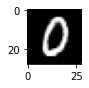

tensor(-3.0209) -661.8893


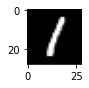

tensor(-15.5052) -629.2693


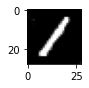

tensor(-0.9681) -641.7017


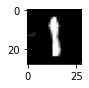

tensor(-20.8332) -633.9472


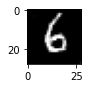

tensor(-15.8422) -634.2387


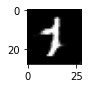

tensor(2.3301) -656.23267


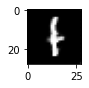

tensor(-11.8192) -461.06537


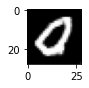

tensor(9.0895) -629.6764


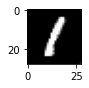

tensor(19.1306) -523.25073


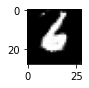

In [0]:
def tensor2image(x):
  return x.detach().numpy().transpose(0, 2, 3, 1)

def image2tensor(x):
  return torch.tensor(x.transpose(0, 3, 1, 2))

def display_image(image):
  plt.figure(figsize=(1,1))
  plt.imshow(image[:,:,0], cmap = 'gray')
  plt.show()


transform = transforms.Compose([
  transforms.Normalize(mean=[0.5,],
                        std=[0.5,])])
inputs = torch.randn((10, 128))
print(inputs.shape)
predictions = G(inputs).cpu()
predictions_numpy = tensor2image(predictions.cpu())
for j, (inpt, prediction) in enumerate(zip(inputs, predictions_numpy)):
  print(inpt.sum(), prediction.sum())
  display_image(prediction)
  if j > 30:
    break